In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import time

# Modern Convolutional Neural Networks

* There is currently no definitive neural network architecture for computer vision tasks.

* This notebook describes some influential convolutional neural network architectures:
    * AlexNet: the first large-scale network to beat alternative computer vision methods on a large-scale vision challenge;
    * VGG: an architecture that makes use of a number of repeating blocks of elements;
    * ResNet: one of the most popular off-the-shelf architectures in computer vision.

* These architectures result from intuition, mathematical insights, and trial-and-error.

* Because new convolutional architectures are constantly being proposed, understanding the motivation behind each architecture is more productive than assuming that a current architecure will stand the test of time.

* This notebook also introduces batch normalization layers, which are part of several modern neural network architectures.



# AlexNet

* In 2009, the ImageNet dataset was released. This dataset contains millions of colored images, each of which contains objects from thousands of different categories.

* An associated competition, called ImageNet Large Scale Visual Recognition Challenge, challenged academics to identify approaches that performed well at a much larger scale than previously considered.

* AlexNet, a convolutional neural network with 8 layers, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a large margin. This is often credited as one of the main causes of the ressurgence in popularity of neural networks.

* Training such a deep neural network in such a large dataset only became feasible for academics thanks to cheap graphical processing units.

## Graphical processing units

* Training neural networks typically involves hundreds of epochs, each of which requires many iterations of expensive operations between tensors.

* By 2012, graphical processing units (GPUs) developed for game graphics were already relatively cheap. Fortunately, these processing units excel at the operations required to implement convolutional neural networks.

* AlexNet was developed for graphical processing units, which at the time required knowledge of low-level GPU libraries.

* Nowadays, frameworks such as PyTorch allow mostly transparent use of different hardware, including GPUs.

* The following code shows how to perform operations between tensors on a GPU using PyTorch.



In [2]:
import torch

# Uncomment one of the following two lines to choose between using a CPU or a GPU.
device = torch.device('cpu') # This object represents a CPU
# device = torch.device('cuda') # This object represents a GPU. If using Google Colab, make sure to select a GPU runtime (Runtime > Change Runtime type).

A = torch.randn(1000, 1000).to(device) # Creates a randomly initialized 1000 x 1000 matrix and moves it to `device`
B = torch.randn(1000, 1000).to(device) # Creates a randomly initialized 1000 x 1000 matrix and moves it to `device`

C = torch.mm(A, B) # Multiplies `A` and `B` using `device`. PyTorch will not perform operations between tensors in different devices.
print(C.device) # `C` is stored in the main memory of the `device`.

cpu


* [CUDA](https://www.nvidia.com/en-gb/geforce/technologies/cuda/) is a parallel computing architecture developed by NVIDIA to harness the computational power of GPUs.

## Implementation

* The next subsections present an adapted and modernized implementation of the AlexNet architecture.




### Dataset

* We will use the [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is composed of labeled images of clothes and accessories.

* We will resize the images in the dataset in order to preserve the AlexNet architecture, which was developed to classify colored images with $224 \times 224$ pixels.

* In contrast with the original AlexNet implementation, we will not employ data augmentation.



In [ ]:
import torchvision

# You don't need to understand this function for now.
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2, pin_memory=True), # Using pinned memory
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)) # Using pinned memory

* Storing data in [pinned memory](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/) speeds up training in a GPU.

In [ ]:
batch_size = 128 # Defines the batch size
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=(224, 224)) # Loads the fashion MNIST dataset. `train_iter` and `test_iter` are `DataLoader` objects.

100%|██████████| 26421880/26421880 [00:01<00:00, 15511195.64it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 261796.41it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4906658.48it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21045104.28it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 128 images per batch. Each image is represented by a 1 x 224 x 224 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size()) # 128 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([128, 1, 224, 224])
torch.Size([128])


* The following code displays some images from the first training batch.



Image 0 (coat):



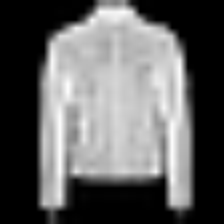


Image 1 (dress):



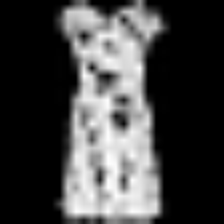


Image 2 (shirt):



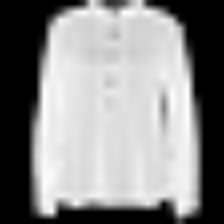

In [ ]:
from google.colab.patches import cv2_imshow

class_labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot'] # Pre-defined class labels

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.

### Architecture

* The following image summarizes the LeNet architecture (left, for a classification task with 10 classes) and the AlexNet architecture (right, for a classification task with 1000 classes).

![LeNet and AlexNet](https://drive.google.com/uc?export=view&id=162g2ADSeL87EVrQY6OyL3ti7J3ZU1M-C)

* Note the differences in number and size of layers and pooling.

* AlexNet also employs dropout and uses a rectified linear activation function instead of a sigmoid activation function.

In [ ]:
class AlexNet(torch.nn.Module):
    def __init__(self, num_outputs):
        super(AlexNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1)
        self.rl1 = torch.nn.ReLU()
        self.max1 = torch.nn.MaxPool2d(3, stride=2)
        self.conv2 = torch.nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.rl2 = torch.nn.ReLU()
        self.max2 = torch.nn.MaxPool2d(3, stride=2)

        self.conv3 = torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.rl3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.rl4 = torch.nn.ReLU()
        self.conv5 = torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.rl5 = torch.nn.ReLU()
        self.max3 = torch.nn.MaxPool2d(3, stride=2)

        self.flatten = torch.nn.Flatten()

        self.linear1 = torch.nn.Linear(6400, 4096)
        self.rl6 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout()
        self.linear2 = torch.nn.Linear(4096, 4096)
        self.rl7 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout()

        self.linear3 = torch.nn.Linear(4096, num_outputs)

    def forward(self, x):
        out = self.conv1(x)
        out = self.rl1(out)
        out = self.max1(out)
        out = self.conv2(out)
        out = self.rl2(out)
        out = self.max2(out)

        out = self.conv3(out)
        out = self.rl3(out)
        out = self.conv4(out)
        out = self.rl4(out)
        out = self.conv5(out)
        out = self.rl5(out)
        out = self.max3(out)

        out = self.flatten(out)

        out = self.linear1(out)
        out = self.rl6(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.rl7(out)
        out = self.dropout2(out)

        out = self.linear3(out)

        return out

In [ ]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10
model = AlexNet(num_outputs).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

### Loss function


In [ ]:
loss = torch.nn.CrossEntropyLoss()

### Optimization Algorithm


In [ ]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Evaluation



In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

tensor(1.)


In [ ]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

In [ ]:
model.eval() # This is necessary because Dropout behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.12851667404174805. Testing accuracy: 0.1306999921798706.


* Executing the cell above takes several minutes in a CPU and less than one minute in a GPU.
* **Google Colab offers limited GPU access to non-subscribers. If you plan on using Google Colab for the programming project without a subscription, you should be very mindful about your GPU usage.**

### Training


Epoch 1/10.
Training accuracy: 0.7171333432197571. Testing accuracy: 0.7103999853134155. Duration: 122.583s.

Epoch 2/10.
Training accuracy: 0.8114166855812073. Testing accuracy: 0.8042999505996704. Duration: 121.500s.

Epoch 3/10.
Training accuracy: 0.8303833603858948. Testing accuracy: 0.8201999664306641. Duration: 128.672s.

Epoch 4/10.
Training accuracy: 0.8716333508491516. Testing accuracy: 0.8611999750137329. Duration: 121.700s.

Epoch 5/10.
Training accuracy: 0.8788666725158691. Testing accuracy: 0.8652999997138977. Duration: 119.924s.

Epoch 6/10.
Training accuracy: 0.8863666653633118. Testing accuracy: 0.8745999932289124. Duration: 121.075s.

Epoch 7/10.
Training accuracy: 0.8956666588783264. Testing accuracy: 0.8823999762535095. Duration: 121.476s.

Epoch 8/10.
Training accuracy: 0.8960333466529846. Testing accuracy: 0.8806999921798706. Duration: 122.200s.

Epoch 9/10.
Training accuracy: 0.8961833715438843. Testing accuracy: 0.8826999664306641. Duration: 123.192s.

Epoch 10/

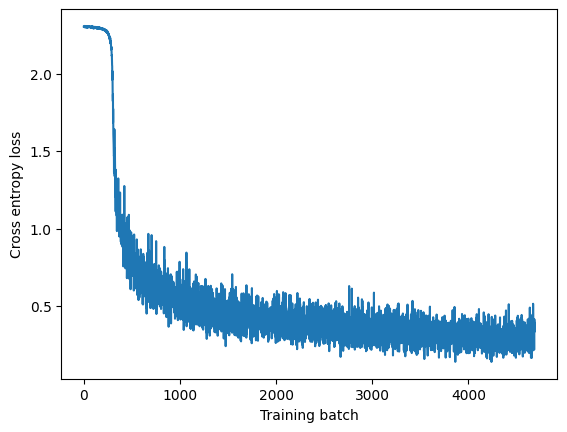

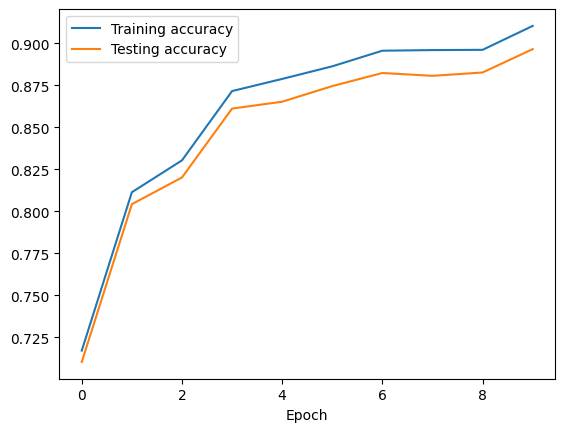

In [ ]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 10
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because Dropout behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because Dropout behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

# VGG

* The VGG architecture was developed at the Visual Geometry Group (VGG) at Oxford University.

* The most remarkable aspect of this architecture is the repeated application of VGG blocks.

* A VGG block receives an image and outputs an image.The block has a pre-defined number of convolutional layers, which are applied sequentially to the input image.

* Every convolutional layer within a VGG block employs the same number of convolutional filters, each with a $3 \times 3$ window and padding $1$. Every convolutional layer also employs a rectified linear activation function.

* After all convolutional layers in a VGG block are sequentially applied, a max-pooling layer with a $2 \times 2$ window and stride $2$ is also applied.

* The following example motivates composing convolutional layers with $3 \times 3$ windows and padding $1$:

    * Consider $2$ convolutional layers, each of which is composed of $c$ filters with a $3 \times 3$ window. Suppose that these convolutional layers are sequentially applied to an input image with $c$ channels. Note that the receptive field of a pixel in the output image corresponds to a $5 \times 5$ window in the input image. Furthermore, note that these convolutional layers have a total of $2(c \cdot c \cdot 3 \cdot 3) = 18c^2$ weights.

    * In order to achieve the same receptive fields and output shape, a single convolutional layer would have to be composed of $c$ filters with a $5 \times 5$ window. However, such a layer would have $c \cdot c \cdot 5 \cdot 5 = 25c^2$ weights. Therefore, the previous alternative requires only $18c^2/25c^2 = 72$% of these weights.

![Receptive field.](https://drive.google.com/uc?export=view&id=1VKAazKVfwUZY_MiONq7Xp8vQflUITyjv)

* The influential VGG-11 architecture employs $5$ VGG blocks. The first $2$ have $1$ convolutional layer each and the last $3$ have $2$ convolutional layers each. The VGG-11 architecture also has $3$ fully connected layers after the VGG blocks, for a total of $11$ layers with parameters. VGG-11 also employs dropout after each of the two first fully connected layers.

## Implementation



### Architecture

* The following image summarizes the AlexNet architecture and the VGG architecture.

![AlexNet and VGG.](https://drive.google.com/uc?export=view&id=1dcgDpG8sFOIBQvz4W6c3vz_6JtJuUHMY)

* The code below implements an adapted version of the VGG-11 architecture.

* Note that a VGG block is implemented as a `torch.nn.Module` so that it can be easily reused.

In [ ]:
class VGGBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, num_convs):
        super(VGGBlock, self).__init__()
        self.num_convs = num_convs

        self.block = []

        for i in range(self.num_convs):
            self.block.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
            input_channels = output_channels

            self.block.append(torch.nn.ReLU())

        self.block.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.block = torch.nn.ModuleList(self.block) # Ensures that each module in the list is considered a submodule of this module

    def forward(self, x):
        for module in self.block:
            x = module(x)

        return x


class VGGNet(torch.nn.Module):
    def __init__(self, conv_arch, num_outputs):
        super(VGGNet, self).__init__()

        self.conv_arch = conv_arch
        self.num_outputs = num_outputs

        input_channels = 1 # Assuming grayscale input images
        modules = []

        for output_channels, num_convs in conv_arch:
            modules.append(VGGBlock(input_channels, output_channels, num_convs))
            input_channels = output_channels

        modules.append(torch.nn.Flatten())
        modules.append(torch.nn.Linear(7 * 7 * input_channels, 4096)) # Assuming 1 x 224 x 224 input images and 5 blocks
        modules.append(torch.nn.ReLU())
        modules.append(torch.nn.Dropout())
        modules.append(torch.nn.Linear(4096, 4096))
        modules.append(torch.nn.ReLU())
        modules.append(torch.nn.Dropout())
        modules.append(torch.nn.Linear(4096, num_outputs))

        self.vgg_modules = torch.nn.ModuleList(modules) # Ensures that each module in the list is considered a submodule of this module

    def forward(self, x):
        for module in self.vgg_modules:
            x = module(x)

        return x

In [ ]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10

# conv_arch = [(64, 1), (128, 1), (256, 2), (512, 2), (512, 2)] # Original VGG-11 architecture (requires large GPU memory)
conv_arch = [(16, 1), (32, 1), (64, 2), (128, 2), (128, 2)] # Adapted VGG-11 architecture (fewer convolutional filters per block)

model = VGGNet(conv_arch, 10).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

VGGNet(
  (vgg_modules): ModuleList(
    (0): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

# Batch Normalization

* Consider a dataset $(\mathbf{x}^{(1)}, y^{(1)}), (\mathbf{x}^{(2)}, y^{(2)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})$ with $n$ examples, where each observation $\mathbf{x}^{(i)}$ corresponds to the target $y^{(i)}$.

* Let the corresponding mean vector $\boldsymbol{\mu}$ and standard deviation vector $\boldsymbol{\sigma}$ be defined by

$$
\begin{aligned}
\boldsymbol{\mu} = \frac{1}{n} \sum_{i = 1}^n \mathbf{x}^{(i)}, \\
\boldsymbol{\sigma} = \sqrt{ \frac{1}{n} \sum_{i = 1}^n(\mathbf{x}^{(i)} - \boldsymbol{\mu})^2},
\end{aligned}
$$
where all operations involving vectors are implicitly elementwise.

* If each observation in the dataset is composed of features with significantly different ranges, it is common to preprocess the original dataset to obtain a standardized dataset $(\mathbf{x'}^{(1)}, y^{(1)}), (\mathbf{x'}^{(2)}, y^{(2)}), \ldots, (\mathbf{x'}^{(n)}, y^{(n)})$ where

$$ \mathbf{x'}^{(i)} = \frac{\mathbf{x}^{(i)} - \boldsymbol{\mu}}{\boldsymbol{\sigma} + \epsilon} $$

and $\epsilon > 0$ is a small constant that prevents division by zero.

* Using the standardized dataset instead of the original dataset ensures that each feature has a comparable effect on the output of a neural network.

* For example, if the first feature corresponds to the number of bedrooms in a house and the second feature corresponds to the distance in meters from the closest train station, changes in the second feature would have a more significant influence on predictions given the same corresponding weight, which is an undesirable bias.

* The main idea behind batch normalization is standardizing the outputs of non-input layers by using statistics computed from a single batch.

* Empirically, batch normalization often accelerates the rate at which the loss decreases during the training of deep neural networks, which has motivated its inclusion in many modern architectures.

* The next subsections decribe batch normalization for vectors and batch normalization for images.


## Batch Normalization for Vectors

* A batch normalization layer for vectors receives a batch composed of vectors and outputs a batch composed of vectors.

* Let $\mathcal{B}$ denote a batch of input vectors. The output $\text{BN}(\mathbf{x})$ of a batch normalization layer for an input vector $\mathbf{x} \in \mathcal{B}$ is defined as

$$ \text{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \boldsymbol{\hat{\mu}_{\mathcal{B}}}}{\boldsymbol{\hat{\sigma}_{\mathcal{B}}} + \epsilon} + \boldsymbol{\beta}, $$

where $\boldsymbol{\hat{\mu}_{\mathcal{B}}}$ is the mean vector for the batch $\mathcal{B}$, $\boldsymbol{\hat{\sigma}_{\mathcal{B}}}$ is the standard deviation vector for the batch $\mathcal{B}$, $\epsilon > 0$ is a small constant that prevents division by zero, $\odot$ denotes elementwise multiplication, and $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ are parameter vectors of the batch normalization layer.

* The elements of $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ are treated as any other parameter (weight or bias) in the neural network. Intuitively, they control the standard deviation and the mean of the outputs produced by the batch normalization layer.

* The following code illustrates how the output of a batch normalization layer for vectors can be computed for a training batch.



In [ ]:
# Computes the output of a batch normalization layer for a training batch `X`
def batch_norm(X, gamma, beta, eps):
    mean = X.mean(dim=0)
    var = ((X - mean) ** 2).mean(dim=0)

    X_hat = (X - mean) / (torch.sqrt(var) + eps)

    return gamma * X_hat + beta  # Scale and shift

X = torch.arange(1., 7.).reshape(2, 3)
print(X)
gamma = torch.tensor([1, 1, 1])
beta = torch.tensor([0, 0, 0])
print(batch_norm(X, gamma, beta, eps=1e-6))

bn = torch.nn.BatchNorm1d(3) # PyTorch batch normalization layer for vectors
print(bn(X))

tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000]])
tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


* Batch normalization layers for vectors are typically applied before the activation function of a fully connected layer.

* Once a neural network that employs batch normalization is trained, statistics (mean vector and standard deviation vector) computed based on the entire dataset are used to make predictions, which guarantees that the same observation will always lead to the same prediction.

* Therefore, just like a dropout layer, a batch normalization layer for vectors operates differently during training and evaluation.

* The choice of batch size becomes considerably more important if batch normalization is employed.

## Batch Normalization for Images

* A batch normalization layer for images receives a batch composed of images and outputs a batch composed of images.

* Let $\mathcal{B}$ denote a batch of input images, each of which has $c$ channels.

* First, the batch normalization layer for images computes a $c$-dimensional vector $\boldsymbol{\hat{\mu}_{\mathcal{B}}}$ that contains the mean pixel value for each channel across every image in the batch $\mathcal{B}$.

* Second, the batch normalization layer for images uses the vector $\boldsymbol{\hat{\mu}_{\mathcal{B}}}$  to compute a $c$-dimensional vector $\boldsymbol{\hat{\sigma}_{\mathcal{B}}}$ that contains the standard deviation of pixel value for each channel across every image in the batch $\mathcal{B}$.

* Finally, for a given input image $\mathbf{x} \in \mathcal{B}$, each channel of the output image $\text{BN}(\mathbf{x})$ of a batch normalization layer results from subtracting the corresponding mean and dividing by the corresponding standard deviation (plus a small constant $\epsilon >0$ that prevents division by zero) and also multiplying by the corresponding element of a $c$-dimensional parameter vector $\boldsymbol{\gamma}$ and adding the corresponding element of a $c$-dimensional parameter vector $\boldsymbol{\beta}$.

* The following code illustrates how the output of a batch normalization layer for images can be computed for a training batch.

In [ ]:
# Computes the output of a batch normalization layer for a training batch `X`
def batch_norm(X, gamma, beta, eps):
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

    X_hat = (X - mean) / (torch.sqrt(var) + eps)

    return gamma * X_hat + beta # Scale and shift

X = torch.tensor([[float(i)]*20 for i in range(1, 7)]).reshape(2, 3, 4, 5)
print(X)
gamma = torch.tensor([1, 1, 1]).reshape(1, 3, 1, 1)
beta = torch.tensor([0, 0, 0]).reshape(1, 3, 1, 1)
print(batch_norm(X, gamma, beta, eps=1e-6))

bn = torch.nn.BatchNorm2d(3) # PyTorch batch normalization layer for images
print(bn(X))

tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.]],

         [[3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.]]],


        [[[4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.]],

         [[5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5.]],

         [[6., 6., 6., 6., 6.],
          [6., 6., 6., 6., 6.],
          [6., 6., 6., 6., 6.],
          [6., 6., 6., 6., 6.]]]])
tensor([[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000,

* Batch normalization layers for images are typically applied before the activation function of a convolutional layer.

* Once a neural network that employs batch normalization is trained, statistics (mean vector and standard deviation vector) computed based on the entire dataset are used to make predictions, which guarantees that the same observation will always lead to the same prediction.

* Therefore, just like a dropout layer, a batch normalization layer for images operates differently during training and evaluation.

* The choice of batch size becomes considerably more important if batch normalization is employed.

# ResNet

* ResNets (residual networks) won the ImageNet Large Scale Visual Recognition Challenge in 2015.

* ResNets employ skip connections, which became a common element in deep neural network architectures.

* Let $f : \mathbb{R}^d \to \mathbb{R}^d$ denote a fully connected layer given by $f(\mathbf{x}) = \text{ReLU}(\mathbf{W} \mathbf{x} + \mathbf{b})$, where $\mathbf{W}$ is a weight matrix and $\mathbf{b}$ is a bias vector.

* For any non-negative vector $\mathbf{x} \in \mathbb{R}^d$, if $\mathbf{W}$ is the $d \times d$ identity matrix and $\mathbf{b} = \mathbf{0}$, then

$$ f(\mathbf{x}) = \text{ReLU} \left( \mathbf{W} \mathbf{x} + \mathbf{b} \right) = \text{ReLU}(\mathbf{x}) = \mathbf{x}. $$

* Under appropriate conditions, the previous equation suggests that including additional fully connected layers could only improve the ability of a neural network to perform well in the training dataset. In the worst case, the additional layers could simply leave their inputs unchanged.

* However, even under appropriate conditions, the empirical evidence shows that including additional fully connected layers often worsens the performance of a neural network in the training dataset.

* Because the additional layers would only require the right parameters to have no effect on the output of the neural network, the necessary conclusion is that current techniques for training neural networks make finding these parameters unlikely.

* A typical example of residual layer is the function $g : \mathbb{R}^d \to \mathbb{R}^d$ given by

$$g(\mathbf{x}) = \text{ReLU}(\mathbf{W} \mathbf{x} + \mathbf{b}) + \mathbf{x},$$
where $\mathbf{W}$ is a weight matrix and $\mathbf{b}$ is a bias vector.

* Note how the input is added to what would be the output of a typical fully connected layer.

* A residual layer is said to have a skip connection because the it allows the input to skip being transformed if the weight matrix $\mathbf{W}$ and the bias vector $\mathbf{b}$ are zero.

* The term residual comes from the fact that the parameters of a residual layer become responsible for producing the residual $\text{ReLU}(\mathbf{W} \mathbf{x} + \mathbf{b}) = g(\mathbf{x}) - \mathbf{x}$ between the output $g(\mathbf{x})$ and the input $\mathbf{x}$.

* The empirical evidence shows that including layers with skip connections under appropriate conditions often only improves the performance of a neural network in the training dataset, which has enabled training neural networks with many hidden layers.

* The ResNet architecture employs skip connections within ResNet blocks, which are covered in the next section.

## ResNet block

* A ResNet block receives an image and outputs an image.

* A ResNet block has a pre-defined number of input channels $c_i$, number of output channels $c_o$, and stride $s$.

* If $c_i = c_o$ and $s = 1$, the input image and the output image have the same shape $c_i \times h_i \times w_i$. In that case:
    1. The input image goes through a convolutional layer with $c_o$ convolutional filters, each with a $3 \times 3$ window, padding $1$, and stride $s$.
    2. The resulting image goes through a batch normalization layer for images and a rectified linear activation function.
    3. The resulting image goes through another convolutional layer with $c_o$ convolutional filters, each with a $3 \times 3$ window, padding $1$, and stride $1$.
    4. The resulting image goes through another batch normalization layer for images.
    5. The resulting image is added to the input image (skip connection).
    6. The resulting image goes through a rectified linear activation function.

* If $c_i \neq c_o$ or $s > 1$, the input image has shape $c_i \times h_i \times w_i$ and the output image has shape $c_o \times \lceil h_i/s \rceil \times \lceil w_i/s \rceil$. In that case:
    1. The input image goes through the first 4 steps described for the previous case.
    2. The input image also goes through a convolutional layer with $c_o$ convolutional filters, each with a $1 \times 1$ window and stride $s$.
    3. The image that results from step 1 is added to the image that results from step 2 (skip connection).
    4. The resulting image goes through a rectified linear activation function.

![ResNet block.](https://drive.google.com/uc?export=view&id=1yNH83-ndmKY0MAa94M9GNKdQU4OUdYAI)

* Note that applying a convolutional filter with a $1 \times 1 $ window is analogous to applying a fully connected layer (with no activation function) across all channels of each pixel in the input image.

* The ResNet block employs convolutions with stride $s > 1$ instead of max pooling to reduce the height and width of input images.


## Architecture

* The following image summarizes the influential ResNet-18 architecture.

![ResNet-18 architecture.](https://drive.google.com/uc?export=view&id=1QTqgZHKRYV_engdzG7ZpsJdRPEzri_ab)

* The input image goes through a convolutional layer with $64$ convolutional filters, each with a $7 \times 7$ window, padding $3$, and stride $2$.

* The resulting image goes through a batch normalization layer for images and a rectified linear activation function.

* The resulting image goes through a max-pooling layer with $3 \times 3$ windows, padding $1$, and stride $2$.

* The resulting image goes through a sequence of four **ResNet macroblocks**, each of which is composed of $2$ ResNet blocks. In total, there are 8 ResNet blocks.

* The first ResNet block in each ResNet macroblock employs stride $2$, which requires the input image to go through a convolutional layer with $1 \times 1$ windows and stride $2$. Because the input image and the output image will necessarily have different shapes, this block also uses the opportunity to double the number of channels.

* Exceptionally, the first ResNet block in the first ResNet macroblock does not employ a convolutional layer with $1 \times 1$ windows. Therefore, its input image and output image will necessarily have the same shape.

* The image resulting from the sequence of four ResNet macroblocks has each of its $512$ channels averaged, resulting in a $512$-dimensional vector that goes through a single fully connected layer to produce a $q$-dimensional vector of logits, where $q$ is the number of classes in the classification problem.

* Each ResNet macroblock has $2 \cdot 2$ convolutional layers (excluding the convolutional layers with $1 \times 1$ windows), for a total of $4 \cdot 4 = 16$ convolutional layers within ResNet macroblocks. Together with the first convolutional layer and the last fully connected layer (outside ResNet macroblocks), there is a total of $18$ layers.

* Note that this architecture employs a single fully connected layer. In contrast, the previously discussed architectures have several large fully connected layers.

* The ResNet-18 architecture was introduced at the same time as the ResNet-152 architecture, which has $152$ layers.

* Neural networks trained for ImageNet image classification (such as ResNet-18 and ResNet-152) are [readily available](https://pytorch.org/vision/stable/models.html).

* It is common to use such pre-trained neural networks as a starting point to solve computer vision tasks, since the features that they detect are generally useful. This is an instance of *tranfer learning*.

* The process of adapting the parameters of a neural network for a new task is called fine-tuning. Before fine-tuning, an original architecture typically has to be adapted by removing or adding layers.

# Recommended reading

* [Dive Into Deep Learning](https://d2l.ai/index.html): Chapter 8.

# [Storing this notebook as a `pdf`]

* In order to store this notebook as a pdf, you will need to hide the images included in the previous cells using the following syntax:
    * `<!--- ![Image caption.](https://link.to.image) --->`

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# Set the path to this notebook below (add \ before spaces). The output `pdf` will be stored in the corresponding folder.
!jupyter nbconvert --to pdf /content/gdrive/My\ Drive/Colab\ Notebooks/nndl/week_08/lecture/02_Modern_Convolutional_Neural_Networks.ipynb

# If having issues, save this notebook (File > Save) and restart the session (Runtime > Restart session) before running this cell. To debug, remove the first line (`%%capture`).